# Задача 24 - множественный регрессионный анализ набора данных "Housing"


Автор: Антонова Алла, студентка группы БИ-3-23-01

### Импорт библиотек

In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
from statsmodels.stats.stattools import jarque_bera
import statsmodels.stats.api as sms
sns.set_style('whitegrid') # установить стиль whitegrid, другие стили можно найти в документации к seaborn
plt.style.use("ggplot")
%matplotlib inline

### Подготовка преобразованных данных для создания выборки
(код запускается лишь один раз для подготовки файла, представлен в скрипте лишь в демонстративных целях)

In [2]:
# # Загрузка данных
# df = pd.read_excel(r"C:\Users\user\Desktop\эконометрика (Наумов В.Н., экзамен)\Экзамен_Антонова\housing.xlsx")
# # Замена пропущенных значений в переменной total_bedrooms медианой
# df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)
# # Преобразование категориальной переменной ocean_proximity в числовую (оne-hot encoding)
# df = pd.get_dummies(df, columns=['ocean_proximity'], prefix='ocean', drop_first=True)
# # Перевод булевого типа данных dummy-переменных (столбцов, получившихся после разделения ocean_proximity) в целочисленный
# dummy_cols = [col for col in df.columns if col.startswith('ocean_')]
# df[dummy_cols] = df[dummy_cols].astype(int)
# # Сохранение файла
# df.to_csv("housing_clean.csv", index = False)

### Сэмплируем преобразованные данные
Загрузим преобразованные данные и соберем стратифицированную выборку (2000 наблюдений). Именно этот вид выборки сохраняет пропорции категорий (даже редких, например как значение ISLAND в ocean_proximity) и структуру набора данных, четко отражает коэффициенты генеральной совокупности - является стандартным подходом в регрессионном анализе (если в наборе есть категориальные переменные)

Для создания стратифицированнлй выборки генеральная совокупность делится на мелкие группы (страты), после чего внутри каждой случайно составляется выборка

In [4]:
orig_df = pd.read_csv(r"C:\Users\user\Desktop\эконометрика (Наумов В.Н., экзамен)\Экзамен_Антонова\housing_clean.csv")
# Восстановление ocean_proximity для стратификации
def decode_ocean(row):
    if row['ocean_INLAND'] == 1:
        return 'INLAND'
    elif row['ocean_ISLAND'] == 1:
        return 'ISLAND'
    elif row['ocean_NEAR BAY'] == 1:
        return 'NEAR BAY'
    elif row['ocean_NEAR OCEAN'] == 1:
        return 'NEAR OCEAN'
    else:
        return '<1H OCEAN>'
orig_df['ocean_proximity'] = orig_df.apply(decode_ocean, axis=1)
# Составляем стратифицированную выборку (2000 наблюдений)
sample_size = 2000
df = orig_df.groupby('ocean_proximity', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), max(1, int(np.ceil(sample_size * len(x) / len(orig_df))))), 
                      random_state=42)
).reset_index(drop=True)
if len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
# Удаляем вспомогательный столбец
df = df.drop(columns=['ocean_proximity'])
# # Сохраняем выборку в отдельный файл
# df.to_csv(r"C:\Users\user\Desktop\эконометрика (Наумов В.Н., экзамен)\Экзамен_Антонова\housing_sample.csv", index=False)
# Предпросмотр: первые 5 строк
print("Первые 5 строк данных:")
print(df.head())
print(df.shape, type(df), df.info(), sep = '\n\n')

Первые 5 строк данных:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -115.40     32.86                19.0       1087.0           171.0   
1    -117.88     34.13                33.0       3713.0           718.0   
2    -117.91     34.14                42.0       2225.0           485.0   
3    -117.26     33.81                22.0       4249.0           922.0   
4    -117.05     34.89                36.0       1199.0           260.0   

   population  households  median_income  median_house_value  ocean_INLAND  \
0       649.0       173.0         3.3182            113800.0             1   
1      2106.0       720.0         4.0023            185500.0             0   
2      1544.0       464.0         2.2442            166700.0             1   
3      2405.0       846.0         2.1549            146500.0             1   
4       665.0       229.0         3.7065             62000.0             1   

   ocean_ISLAND  ocean_NEAR BAY  ocean_NEAR OCEAN  
0    

C:\Users\user\AppData\Local\Temp\ipykernel_12884\335378600.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = orig_df.groupby('ocean_proximity', group_keys=False).apply(


Все переменные без пропусков, типы данных корректны (числовые признаки — float64, dummy-переменные — int64). Отрицательные значения longitude и latitude сохранены, что критично для географической интерпретации.

## Анализ корреляции переменных

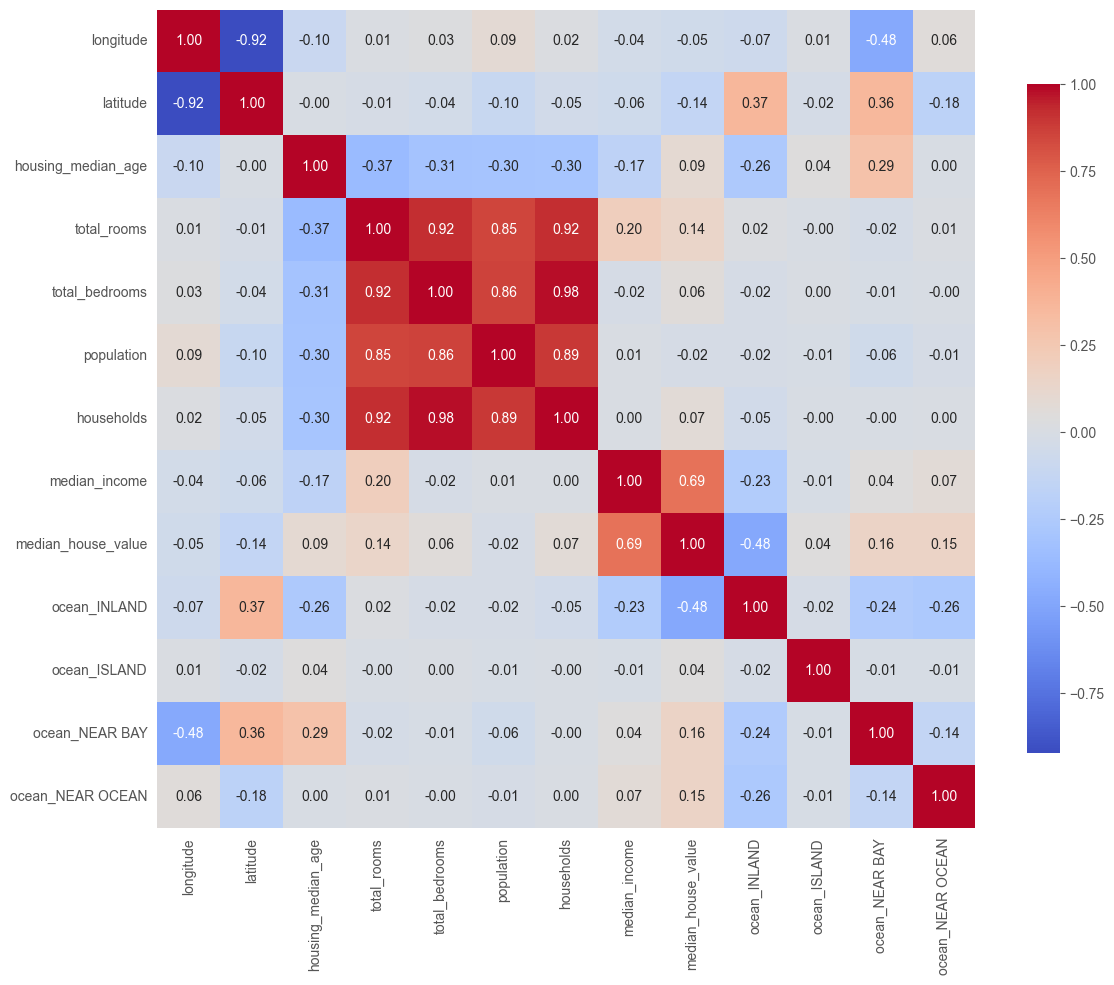

In [4]:
# Построение тепловой карты
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.tight_layout()

- Существует сильная отрицательная корреляция между longitude и latitude (r = -0.92) - чем западнее (меньше долгота, longitude), тем севернее (больше широта, latitude)
- total_rooms, total_bedrooms, population, households  сильно коррелируют друг с другом (r > 0.85) - чем больше домов, тем больше население, количество комнат, спален и хозяйств:
- Наиболее сильная положительная связь целевой переменной с median_income (r = 0.69) - чем выше доход в районе, тем выше стоимость дома
- Самая высокая отрицательная связь стоимости дома (целевая переменная) с переменной ocean_INLAND  (r = -0.48) — действительно, дома в глубине суши дешевле, чем у океана
    
    Интересно, что переменная ocean_NEAROCEAN имеет небольшую корреляцию с ценой дома (r = 0.15) - видимо, расположение на берегу окена не играет такой значимой роли при вычислении стоимости дома. Такой же вывод можно сделать и по ocean_NEARBAY - географическое положение рядом с заливами не сильно влияет на стоимость домов в тех районах


#### Построение линейной регрессионной модели с помощью библиотеки Statsmodels

In [5]:
# Разделение переменных на целевую и факторы, влияющие на нее
X = df.drop(columns=["median_house_value"])
y = df["median_house_value"]
# Добавление константы (intercept)
X = sm.add_constant(X)
# Строим модель OLS (методом наименьших квадратов)
model = sm.OLS(y, X).fit()
# Выводим сводку модели
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     298.4
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:03:54   Log-Likelihood:                -25121.
No. Observations:                2000   AIC:                         5.027e+04
Df Residuals:                    1987   BIC:                         5.034e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.654e+06   2.75

Согласно результатам метода наименьших квадратов вот основные характеристики модели OLS:
- Модель объясняет 64.3% дисперсии Y (стоимости дома в Калифорнии) - средний результат
- F-статистика: 298.4, p=0.000 — модель в целом статистически значима.
- Статистически незначимы только коэффициенты при ocean_NEAR BAY (p = 0.886) и ocean_NEAR OCEAN (p = 0.317) - > отсутствует достоверное влияние этих категорий на цену относительно базовой (<1H OCEAN>).
- Значимые коэффициенты показывают, что географическое положение (longitude, latitude, ocean_INLAND) и доход (median_income) оказывают сильное влияние на цену.
- Сильная мультиколлинеарность: условное число (Cond. No.) = 6.93e+0 указывает на сильную зависимость между предикторами
- существует ассиметричность (Skew = 1.212) и возможны выбросы (Kurtosis = 6.120 -> тяжелые хвосты)
- Существует сильная положительная автокорреляция остатков (Durbin-Watson = 1.979)

## Диагностика получившейся модели

### Построение графиков для анализа остатков

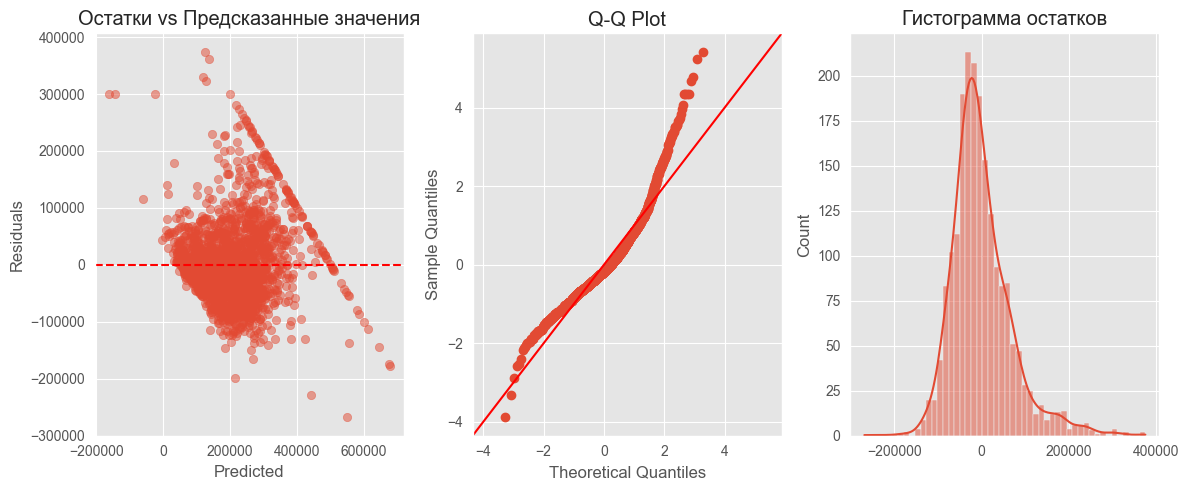

In [6]:
# Остатки vs Предсказанные значения (тест на гомоскедастичность) 
y_pred = model.predict(X)
residuals = y - y_pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Остатки vs Предсказанные значения")
# Q-Q plot (тест на нормальность распределения остатков) 
sm.qqplot(residuals, line='45', fit=True, ax=plt.subplot(1, 3, 2))
plt.title("Q-Q Plot")
#Гистограмма остатков (тест на нормальность распределения остатков)
plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True, bins=50)
plt.title("Гистограмма остатков")
plt.tight_layout()

1. Остатки vs Предсказанные значения (тест на гомоскедастичность)

Существуют очень большие остатки (один положительный и один отрицательный), дисперсия увеличивается с ростом предсказаний и облако точек слегка наклонено вниз справа, что указывает на систематическую ошибку модели при высоких прогнозах

2. Q-Q Plot (тест на нормальность распределения остатков)

Точки сильно отклоняются от диагональной прямой, особенно в хвостах - видны резкие выбросы, остатки нормально не распределены. Выбросы в верхнем правом и нижнем левом углах указывают на наличие экстремальных значений, которые тянут распределение в сторону тяжёлых хвостов 

3. Гистограмма остатков (тест на нормальность распределения остатков)

Гистограмма сильно скошена влево, с правой стороны есть длинный хвост - свидетельство сильной положительной ассиметрии. Есть множество крупных положительных остатков, что говорит о систематическом занижении стоимости домов в некоторых районах, что так же подтверждается выводами из корреляционного анализа

### Анализ выбросов - расстояние Кука

Влиятельные наблюдения: 114 шт.
Первые индексы: [ 19  26  54  65 106 133 159 175 179 184]

Наиболее влиятельное наблюдение:
  Индекс: 857


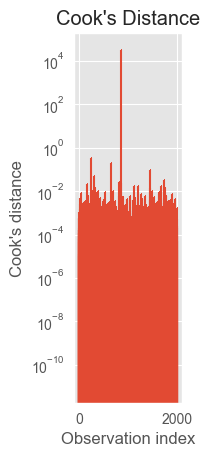

In [7]:
influence = model.get_influence()
(c, p) = influence.cooks_distance
n = len(df)
threshold = 4 / n
influential = np.where(c > threshold)[0]
plt.subplot(1, 4, 4)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.yscale("log")
print(f"Влиятельные наблюдения: {len(influential)} шт.")
if len(influential) > 0:
    print(f"Первые индексы: {influential[:10]}")
max_cook_idx = np.argmax(c)  # индекс наблюдения с максимальным Cook's Distance
max_cook_value = c[max_cook_idx]
print(f"\nНаиболее влиятельное наблюдение:")
print(f"  Индекс: {max_cook_idx}")

Попробуем удалить самое влиятельное наблюдение (857) и построить модель лин.регрессии без него - > так мы получим модель без экстремумов

### Построение линейной модели без экстремумов

In [8]:
# Исключаем наблюдение с индексом 857
df_clean = df.drop(index=857)
# Разделение переменных на целевую и факторы
X_clean = df_clean.drop(columns=["median_house_value"])
y_clean = df_clean["median_house_value"]
# Добавление константы (intercept)
X_clean = sm.add_constant(X_clean)
# Строим модель OLS без влиятельного наблюдения
model = sm.OLS(y_clean, X_clean).fit()
# Выводим сводку модели
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     324.7
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:23:34   Log-Likelihood:                -25109.
No. Observations:                1999   AIC:                         5.024e+04
Df Residuals:                    1987   BIC:                         5.031e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.654e+06   2.75

- R² и Adj R² остались на том же уровне — модель объясняет ту же долю дисперсии, что говорит о стабильности.
- F-статистика выросла с 298 до 324.7 — это положительный сигнал: модель стала более статистически значимой, возможно, за счёт удаления аномалии, которая "разбавляла" общий эффект.
- AIC уменьшился — это указывает на улучшение качества модели (чем меньше AIC — тем лучше).
- BIC почти не изменился — также говорит о стабильности.
- Малое изменение коэффициентов — например, median_income остался на уровне 39 760 — это хорошо, значит, влияние выброса было локальным, а не системным.

Удаление влиятельного наблюдения пошло на пользу модели, значит будет работать далее только с ней

In [9]:
# Удаляем влиятельное наблюдение и обновляем основные переменные
df = df.drop(index=857)
X = df.drop(columns=["median_house_value"])
y = df["median_house_value"]
X = sm.add_constant(X)

#### Тест Харке—Бера (проверка на нормальность остатков)

In [11]:
y_pred = model.predict(X)
residuals = y - y_pred
jarqueb_test = jarque_bera(residuals)
print(f"Тест Харке-Бера на нормальность остатков: p-value = {jarqueb_test[1]:.4e}")
print(f"Ассиметрия: {jarqueb_test[2]:.4f}")
print(f"Эксцесс: {jarqueb_test[3]:.4f}")
if jarqueb_test[1] < 0.05:
    print("Распределение остатков не нормально")
else:
    print("Распределение остатков нормально")

Тест Харке-Бера на нормальность остатков: p-value = 1.0318e-282
Ассиметрия: 1.2117
Эксцесс: 6.1173
Распределение остатков не нормально


Асимметрия положительная и умеренно выраженная (skew = 1.21) — распределение смещено вправо: правый хвост длиннее левого, что указывает на наличие редких, но значительных положительных отклонений

Эксцесс высокий (kurtosis = 6.12) — распределение имеет «тяжёлые» хвосты и острый пик по сравнению с нормальным. Судя по нему, выбросов много, данные больше сгруппированы вокруг центра и хвостов - в сравнении с нормальным распределением

### ТЕст Дарбина-Ватсона на автокорреляцию остатков

In [12]:
durbinw_test = sm.stats.stattools.durbin_watson(residuals)
print(f"Тест Дарбина-Ватсона (линейная модель): {durbinw_test:.4f}")
if durbinw_test < 1.5:
    print("Возможна положительная автокорреляция (DW < 1.5)")
elif durbinw_test > 2.5:
    print("Возможна отрицательная автокорреляция (DW > 2.5)")
else:
    print("Автокорреляция маловероятна (1.5 ≤ DW ≤ 2.5)")

Тест Дарбина-Ватсона (линейная модель): 1.9794
Автокорреляция маловероятна (1.5 ≤ DW ≤ 2.5)


Тест Дарбина–Уотсона дал значение DW = 1.979, что находится в диапазоне 1.5–2.5 — следовательно, автокорреляция остатков маловероятна.

Это неожиданный, но положительный результат для географических данных: несмотря на то, что расположенные рядом дома действительно имеют схожие цены (пространственная зависимость), модель не демонстрирует систематической корреляции между соседними ошибками. 

#### Вывод t-значений; расчет AIC и MSE

1) AIC (Akaike Information Criterion) — Информационный критерий Акаике показывает насколько хороша модель. Чем ниже - тем выше качество модели. 
2) MSE (Mean Squared Error) — Среднеквадратичная ошибка. Простыми словами - насколько в среднем модель ошибается, чем ниже MSE - тем лучше модель предсказывает

In [13]:
print('T-values:', model.tvalues, '\n') # T-значения коэффициентов
print('AIC:', model.aic, '\n')
print('MSE:', model.mse_resid) # MSE (среднеквадратичная ошибка остатков)

T-values: const                 -6.021121
longitude             -6.264349
latitude              -6.350963
housing_median_age     8.559080
total_rooms           -2.262077
total_bedrooms         3.293157
population           -10.817612
households             2.745529
median_income         37.275409
ocean_INLAND          -7.085840
ocean_ISLAND           1.187950
ocean_NEAR BAY         0.142919
ocean_NEAR OCEAN       1.001173
dtype: float64 

AIC: 50242.118045385294 

MSE: 4789844853.353822


- Модель показывает высокую статистическую значимость большинства коэффициентов (t-значения особенно median_income и population - подтверждают влияние уровня дохода и плотности населения на стоимость жилья)
- Однако очень высокий MSE (4.8 млрд) - указывает на крупные прогнозные ошибки, модели не удается верно угадать стоимость дома, особенно для дорогих объектов
- Значение AIC (~50 242) в сравнении с MSE кажется маленьким - удовлетворимое качество модели, позволяет сравнивать модель с альтернативами

В совокупности с нарушениями предпосылок МНК (гетероскедастичность, ненормальность остатков), выводы говорят о том, что модель пригодна для интерпретации направления влияния факторов, но прогнозирование по ней не будет надежным. Для прогнозирования требуется построить более точную модель

### Расчет VIF (Variance Inflation Factor)

In [14]:
# VIF (Variance Inflation Factor) измеряет степень мультиколлинеарности между независимыми переменными в модели множественной регрессии
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.round(2))

               feature       VIF
0                const  31483.38
1            longitude     17.18
2             latitude     19.15
3   housing_median_age      1.40
4          total_rooms     11.39
5       total_bedrooms     36.81
6           population      5.82
7           households     41.90
8        median_income      1.76
9         ocean_INLAND      2.86
10        ocean_ISLAND       NaN
11      ocean_NEAR BAY      1.58
12    ocean_NEAR OCEAN      1.19


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


- Наблюдается сильная мультиколлинеарность: у многих признаков VIF > порогового значения 5. Особенно выражена проблема у households (VIF = 41.91), total_bedrooms (VIF = 36.81), а также у географических координат — latitude (VIF = 19.16) и longitude (VIF = 17.18)
- Из-за масштаба данных и высокой корреляции между переменными особенно высокий VIF у константы (const ~ 31.5) 

#### Проверка гетероскедастичности: тест Голдфельда–Квандта

In [15]:
goldfeldq_test = het_goldfeldquandt(model.resid, model.model.exog)
print(f"Тест Голдфельда–Квандта: p = {goldfeldq_test[1]:.4f}")
if goldfeldq_test[1] < 0.05:
    print("Существует гетероскедастичность по тесту Голдфельда–Квандта")
else:
    print("Гетероскедастичность по тесту Голдфельда–Квандта не обнаружена")

Тест Голдфельда–Квандта: p = 0.9718
Гетероскедастичность по тесту Голдфельда–Квандта не обнаружена


#### Тест Бреуша–Пагана (Bresuch-Pagan) — альтернативный тест на гетероскедастичность

In [16]:
breuschp_test = sms.het_breuschpagan(model.resid, model.model.exog)
if breuschp_test[1] < 0.05:
    print("Существует гетероскедастичность по тесту Бреуша–Пагана")
else:
    print("Гетероскедастичность по тесту Бреуша–Пагана не обнаружена")

Существует гетероскедастичность по тесту Бреуша–Пагана


Тесты дают противоречивые результаты: 
- Бреуш–Паган указывает на гетероскедастичность, а Голдфельд–Квандт — нет. При большой выборке (n > 1000) Бреуш-Паган сверхчувствителен, поэтому гетероскедастичность, скорее всего, присутствует в слабой форме

## Построение модели множественной линейной регрессии с робастными стандартными данными

Множественная линейная регрессия сама по себе показывала хорошее значение R-квадрат (64.5% дисперсии зависимой переменной объясняется моделью). Использование робастных стандартных ошибок (HC3, используется только при гетероскедастичности) корректирует стандартные ошибки при гетероскедастичности, делая p-значения и доверительные интервалы надёжным

In [14]:
# Построение модели робастной регрессии
model_robust = sm.OLS(y, X).fit(cov_type='HC3')
print(model_robust.summary())
# Диагностика улучшенной модели
residuals_robust = model_robust.resid

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     278.6
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:11:57   Log-Likelihood:                -25121.
No. Observations:                2000   AIC:                         5.027e+04
Df Residuals:                    1987   BIC:                         5.034e+04
Df Model:                          12                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.654e+06   2.93

#### Тесты на гетероскедастичность на измененной модели

In [15]:
# Тест Голдфельда–Квандта
goldfeldq_test = het_goldfeldquandt(residuals_robust, X)
print(f"\nТест Голдфельда–Квандта: p = {goldfeldq_test[1]:.4f}")
if goldfeldq_test[1] < 0.05:
    print("Существует гетероскедастичность по тесту Голдфельда–Квандта")
else:
    print("Гетероскедастичность по тесту Голдфельда–Квандта не обнаружена")

# Тест Бреуша–Пагана
breuschp_test = sms.het_breuschpagan(residuals_robust, X)
print(f"Тест Бреуша–Пагана: p = {breuschp_test[1]:.4f}")
if breuschp_test[1] < 0.05:
    print("Существует гетероскедастичность по тесту Бреуша–Пагана")
else:
    print("Гетероскедастичность по тесту Бреуша–Пагана не обнаружена")


Тест Голдфельда–Квандта: p = 0.9718
Гетероскедастичность по тесту Голдфельда–Квандта не обнаружена
Тест Бреуша–Пагана: p = 0.0000
Существует гетероскедастичность по тесту Бреуша–Пагана


#### Тест Харке–Бера на нормальность остатков

In [16]:
jarqueb_test = sms.jarque_bera(residuals_robust)
print(f"Тест Харке-Бера: JB = {jarqueb_test[0]:.4f}, p = {jarqueb_test[1]:.4f}")
if jarqueb_test[1] < 0.05:
    print("Остатки не нормально распределены")
else:
    print("Остатки нормально распределены")

Тест Харке-Бера: JB = 1301.0805, p = 0.0000
Остатки не нормально распределены


#### Расчёт AIC, MSE для анализа качества робастной модели

In [17]:
print(f"AIC = {model_robust.aic:.4f}")
print(f"MSE = {model_robust.mse_resid:.6f}")

AIC = 50268.2394
MSE = 4789844853.353816


### Расчет VIF (Variance Inflation Factor) для робастной регрессии

In [18]:
# VIF (Variance Inflation Factor) измеряет степень мультиколлинеарности между независимыми переменными в модели множественной регрессии
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.round(2))

               feature       VIF
0                const  31499.13
1            longitude     17.18
2             latitude     19.16
3   housing_median_age      1.41
4          total_rooms     11.39
5       total_bedrooms     36.81
6           population      5.82
7           households     41.91
8        median_income      1.76
9         ocean_INLAND      2.86
10        ocean_ISLAND      1.01
11      ocean_NEAR BAY      1.58
12    ocean_NEAR OCEAN      1.19


### Тест Дарбина-Ватсона на автокорреляцию остатков

In [25]:
durbinw_test = sm.stats.stattools.durbin_watson(residuals_robust)
print(f"\nТест Дарбина-Ватсона (робастные ош): {durbinw_test:.4f}")
if durbinw_test < 1.5:
    print("Возможна положительная автокорреляция (DW < 1.5)")
elif durbinw_test > 2.5:
    print("Возможна отрицательная автокорреляция (DW > 2.5)")
else:
    print("Автокорреляция маловероятна (1.5 ≤ DW ≤ 2.5)")


Тест Дарбина-Ватсона (робастные ош): 1.9793
Автокорреляция маловероятна (1.5 ≤ DW ≤ 2.5)


Построенная модель множественной линейной регрессии, в которой для оценки статистической значимости коэффициентов использованы робастные стандартные ошибки (HC3), демонстрирует хорошее качество подгонки (R² = 0.643) и статистическую значимость ключевых факторов, таких как доход и географическое положение. Несмотря на наличие гетероскедастичности и мультиколлинеарности, использование робастных стандартных ошибок (HC3) обеспечивает надёжность статистических выводов. 

## Попробуем построить логарифмическую модель

In [20]:
# Логарифмическая модель: log(Y) ~ X
y_log = np.log(y)
model_log = sm.OLS(y_log, X).fit()
# Расчет остатков
residuals_log = model_log.resid
print(model_log.summary())
# R-квадрат на логарифмической шкале
print(f"\nR-квадрат: {model_log.rsquared:.4f}")

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     317.4
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        12:11:58   Log-Likelihood:                -652.84
No. Observations:                2000   AIC:                             1332.
Df Residuals:                    1987   BIC:                             1404.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9897      1

#### Тесты на гетероскедастичность логарифмической модели

In [21]:
# Тест Голдфельда–Квандта
goldfeldq_test = het_goldfeldquandt(residuals_log, X)
print(f"\nТест Голдфельда–Квандта (лог-модель): p = {goldfeldq_test[1]:.4f}")
if goldfeldq_test[1] < 0.05:
    print("Существует гетероскедастичность по тесту Голдфельда–Квандта")
else:
    print("Гетероскедастичность по тесту Голдфельда–Квандта не обнаружена")

# Тест Бреуша–Пагана
breuschp_test = sms.het_breuschpagan(residuals_log, X)
print(f"Тест Бреуша–Пагана (лог-модель): p = {breuschp_test[1]:.4f}")
if breuschp_test[1] < 0.05:
    print("Существует гетероскедастичность по тесту Бреуша–Пагана")
else:
    print("Гетероскедастичность по тесту Бреуша–Пагана не обнаружена")


Тест Голдфельда–Квандта (лог-модель): p = 0.9488
Гетероскедастичность по тесту Голдфельда–Квандта не обнаружена
Тест Бреуша–Пагана (лог-модель): p = 0.0000
Существует гетероскедастичность по тесту Бреуша–Пагана


#### Тест Харке–Бера на нормальность остатков

In [22]:
jarqueb_test = sms.jarque_bera(residuals_log)
print(f"Тест Харке-Бера (лог-модель): JB = {jarqueb_test[0]:.4f}, p = {jarqueb_test[1]:.4f}")
if jarqueb_test[1] < 0.05:
    print("Остатки не нормально распределены")
else:
    print("Остатки нормально распределены")

Тест Харке-Бера (лог-модель): JB = 565.7419, p = 0.0000
Остатки не нормально распределены


#### Расчёт AIC, MSE для анализа качества логарифмической модели

In [23]:
print(f"AIC = {model_log.aic:.4f}")
print(f"MSE = {model_log.mse_resid:.6f}")

AIC = 1331.6839
MSE = 0.113210


- AIC = 1331.68 — значительно ниже, чем у исходной OLS-модели (~50 268), что указывает на лучшую относительную качество подгонки при учёте числа параметров. Однако из-за разного шкалирования прямое сравнение результатов линейных и лоагрифмическихх моделей некорректно
- MSE также нельзя напрямую сравнивать с OLS ( ~4.8 млрд), однако низкий MSE на логарифмической шкале говорит о хорошей внутренней согласованности модели.

### Тест Дарбина-Ватсона на автокорреляцию остатков

In [24]:
durbinw_test = sm.stats.stattools.durbin_watson(residuals_log)
print(f"\nТест Дарбина-Ватсона (лог-модель): {durbinw_test:.4f}")
if durbinw_test < 1.5:
    print("Возможна положительная автокорреляция (DW < 1.5)")
elif durbinw_test > 2.5:
    print("Возможна отрицательная автокорреляция (DW > 2.5)")
else:
    print("Автокорреляция маловероятна (1.5 ≤ DW ≤ 2.5)")


Тест Дарбина-Ватсона (лог-модель): 1.9869
Автокорреляция маловероятна (1.5 ≤ DW ≤ 2.5)


Метрики AIC и MSE подтверждают, что логарифмическая модель хорошо подогнана к данным на своей шкале. Это согласуется с более высоким R² (0.657 против 0.643) и часто наблюдаемым улучшением гомоскедастичности после логарифмирования цен на жильё.